# Visualize ISC

This script finds the networks that exhibit a decrease in ISC over time. Specifically, the 'vis' version perfroms sevral different plotting functions

## py conversion

In [1]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [2]:
import warnings
import sys  
import random
import os
import os.path

import deepdish as dd
import numpy as np
import pandas as pd

import scipy.io
from scipy import stats
from scipy.stats import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

#plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

# nil and nib 
import nibabel as nib
import nilearn as nil

from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from nilearn.plotting import plot_stat_map

# Brainiak # 
from brainiak import image, io 
import brainiak.utils.fmrisim as sim  
from brainiak import image, io
import brainiak.eventseg.event
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests

from brainiak.isc import squareform_isfc
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
random.seed(10)

## custom helper functions 

In [4]:
## imports
from utils_anal import load_epi_data, resample_atlas, get_network_labels

## directories 

In [5]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


In [6]:
work_dir

'/jukebox/graziano/coolCatIsaac/MEI/data/work'

# Visualize

## images 

In [200]:
sigvox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()


In [201]:
run = 2
mov_img = sigvox['external']['sherlock'][run]

In [60]:
mov_3d_ = mov_img.get_fdata()
nan_mask = np.isnan(mov_3d_)
filt = np.where(nan_mask, 0, mov_3d_)
filt_sig = np.where(mov_3d_ != 0)
filt_nosig = np.where(filt == 0)
mov_3d = nib.Nifti1Image(filt, affine=mov_img.affine,header=mov_img.header)

In [44]:
## count of sig voxels ## 
print(f"{len(filt_sig[1])} out of  "
      f"{len(filt_nosig[0]) + len(filt_sig[1])} voxels")

471510 out of  897831 voxels


In [37]:
len(filt_sig[1])

471510

In [29]:
len(filt_nosig[0])

438137

In [9]:
#plotting.view_img_on_surf(mov_3d, threshold =.05,surf_mesh='fsaverage', colorbar=True,  vmax  =.7)

# get correlation dic for 17 nets 

In [86]:
# load unthresh image 
#isc_nii_nt_all = np.load(f'{isc_dir}/n_33_isc_noThresh_nii_dic.npy', allow_pickle = True).item()
#isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()
isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [87]:
##### Variables for ISC ### 

num_parc = 200 ## CHANGE ME
num_net= 17 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

## mask info ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")
mask_coords = np.where(mask_img)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


In [88]:
mov = 'sherlock'
cond = 'internal'
run_list = [1,2,3,4]
networkz = ['L VisCent', 'L DefaultA'] #'R DorsAttnB'

# static
cor_dic = {cond: {mov: {}  for mov in mov_list} for cond in cond_list}

In [271]:
isc_nii_nt = isc_nii_nt_all[cond][mov]
isc_nii_nt

{1: <nibabel.nifti1.Nifti1Image at 0x7ff75f394090>,
 2: <nibabel.nifti1.Nifti1Image at 0x7ff75f17fe50>,
 3: <nibabel.nifti1.Nifti1Image at 0x7ff75f0dde10>,
 4: <nibabel.nifti1.Nifti1Image at 0x7ff75d7fc250>}

In [272]:
for run in run_list:
    # Convert to 4d numpy array
    f_dat_4d = isc_nii_nt[run].get_fdata()

    for net_lab in network_labels:
        targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
        #print(net_lab)

        temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
        if net_lab not in cor_dic[cond][mov]:
            cor_dic[cond][mov][net_lab] = [np.round(np.nanmean(temp),5)]
            #print(np.round(np.nanmean(temp),5))
        else:
            cor_dic[cond][mov][net_lab].append(np.round(np.nanmean(temp),5))

In [273]:
cond

'internal'

In [274]:
new_dic = {}
for net in networkz:
    new_dic[net] = cor_dic[cond][mov][net]

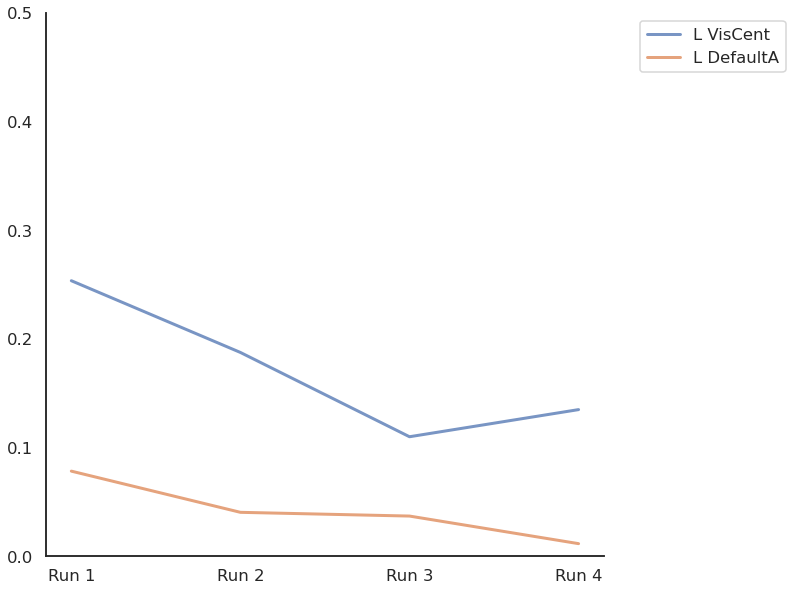

In [275]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

color_mapping = {}
handles = []
for key in new_dic:
    line, = ax.plot(new_dic[key], alpha=0.75, linewidth=3, label=key)
    handles.append(line)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
# Set the maximum y-axis limit to 0.5
ax.set_ylim(0, 0.5)

sns.despine()
plt.show()

# One video

In [16]:
# load unthresh image 
#isc_nii_nt_all = np.load(f'{isc_dir}/n_33_isc_noThresh_nii_dic.npy', allow_pickle = True).item()
#isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()
isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [135]:
##### Variables for ISC ### 

num_parc = 200 ## CHANGE ME
num_net= 17 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

## mask info ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")
mask_coords = np.where(mask_img)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


In [210]:
mov = 'sherlock'
cond = 'external'
run_list = [1,2,3,4]
mov_list = ['office', 'brushing', 'oragami', 'shrek', 'cake', 'sherlock']


In [152]:
high_movies =['shrek', 'office', 'sherlock']
low_movies = ['brushing', 'oragami', 'cake']

In [153]:
isc_nii_nt = isc_nii_nt_all[cond][mov]
isc_nii_nt

{1: <nibabel.nifti1.Nifti1Image at 0x7f0f7ca8d910>,
 2: <nibabel.nifti1.Nifti1Image at 0x7f0f7ca8d9d0>,
 3: <nibabel.nifti1.Nifti1Image at 0x7f0f7ca8da90>,
 4: <nibabel.nifti1.Nifti1Image at 0x7f0f7ca8db50>}

In [182]:
roi_dic_aparc = {
    'RH_SomMotB_Aud_1' : 21, #124
    'RH_VisCent_ExStr_1' : 101,
    'RH_DefaultA_IPL_1': 184,
    'RH_DefaultA_PFCm_3': 189
    #'LH_DefaultB_PFCd_3': 90
    
}

In [231]:
### VISUAl 
roi_dic_aparc = {
    1 : 101,
    2 : 102,
    3 : 103,
    4 : 104,
    5 : 105,
    6 : 106,
    7 : 107
}

In [203]:
# get ROI labels and roi_num
roi_dic_aparc = np.load(f'{mask_dir}/roi_dic_aparc_n20_2.npy', allow_pickle = True).item()
roi_dic_aparc['LH_SomMotB_Aud_2'] = 45
roi_dic_aparc

{'RH_DefaultA_PFCm_1': 187,
 'RH_DefaultA_PFCm_3': 189,
 'LH_DefaultB_PFCd_3': 90,
 'RH_DefaultB_PFCd_1': 192,
 'LH_DefaultA_pCunPCC_3': 79,
 'LH_DefaultA_pCunPCC_1': 77,
 'RH_DefaultA_IPL_1': 184,
 'RH_ContB_PFCld_2': 176,
 'RH_ContA_PFCd_1': 167,
 'RH_ContB_PFCld_1': 175,
 'RH_SalVentAttnA_FrMed_1': 147,
 'RH_ContB_IPL_2': 174,
 'LH_DorsAttnB_FEF_1': 39,
 'RH_DorsAttnB_FEF_1': 141,
 'RH_DorsAttnA_SPL_2': 134,
 'RH_DorsAttnA_SPL_4': 136,
 'RH_SalVentAttnA_Ins_1': 144,
 'LH_DefaultB_Temp_1': 83,
 'RH_VisCent_Striate_1': 103,
 'LH_SomMotA_5': 17,
 'LH_SomMotB_Aud_2': 45}

### start 

In [232]:
targ_anal = 'rois'

##### Get parcels associated with the target network #### 
if targ_anal == 'rois':
    network_label_list = list(roi_dic_aparc.keys())
elif targ_anal == 'networks':
    network_label_list = network_labels
else:
    print('error in input! yikess')
    sys.exit()



## create dictionary for all roi, all conditions, all runs ## 
roi_dict = {}
#sub_list = ['sub-024']


for net_lab in network_label_list:
    print(f'start {net_lab}')
    
    ##### Get parcels associated with the target network #### 
    if targ_anal == 'rois':
        targ_net = np.array([roi_dic_aparc[net_lab]])
    elif targ_anal == 'networks':
        targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
        print(targ_net)
    else:
        print('error in input! yikess')
        sys.exit()
    

start 1
start 2
start 3
start 4
start 5
start 6
start 7


In [233]:
## this is the 8****new code 
cond = 'external'

In [234]:
# static
cor_dic = {cond: {mov: {}  for mov in mov_list} for cond in cond_list}

for mov in mov_list:
    isc_nii_nt = isc_nii_nt_all[cond][mov]
    for run in run_list:
        # Convert to 4d numpy array
        f_dat_4d = isc_nii_nt[run].get_fdata()

        for net_lab in network_label_list:
            targ_net = roi_dic_aparc[net_lab] +1
            #print(net_lab)

            temp = np.nanmean(f_dat_4d[atlas_img == targ_net])
            if net_lab not in cor_dic[cond][mov]:
                cor_dic[cond][mov][net_lab] = [np.round(np.nanmean(temp),5)]
                #print(np.round(np.nanmean(temp),5))
            else:
                cor_dic[cond][mov][net_lab].append(np.round(np.nanmean(temp),5))

### ONE MOVIE 

In [214]:
new_dic = {}
for net in network_label_list:
    new_dic[net] = cor_dic[cond][mov][net]
    

### high vs low

In [235]:
new_dic = {}
salience_type = high_movies
for net in network_label_list:      
    temp = []
    for mov in salience_type:
        temp.append(cor_dic[cond][mov][net])
    new_dic[net] = np.mean(np.array(temp),axis = 0)

In [236]:
new_dic

{1: array([0.38961   , 0.34260667, 0.30724667, 0.27534   ]),
 2: array([0.35356333, 0.3594    , 0.31347   , 0.26446333]),
 3: array([0.32613   , 0.30290667, 0.26736333, 0.22993333]),
 4: array([0.37516667, 0.3658    , 0.31642333, 0.28890667]),
 5: array([0.43111   , 0.41736333, 0.36882   , 0.31899   ]),
 6: array([0.42516667, 0.38597   , 0.33497   , 0.29474667]),
 7: array([0.23692333, 0.16510333, 0.14012667, 0.13934667])}

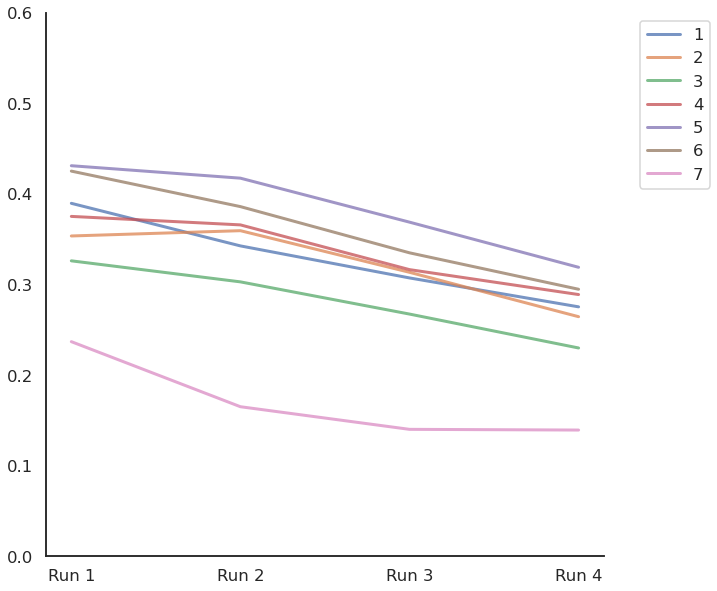

In [237]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['Run 1', 'Run 2', 'Run 3', 'Run 4']
#new_targs = ['RH_DorsAttnA_SPL_2', 'RH_VisCent_Striate_1', 'RH_DefaultA_PFCm_3', 'LH_DefaultA_pCunPCC_3']

color_mapping = {}
handles = []
for key in new_dic: #new_dic
    line, = ax.plot(new_dic[key], alpha=0.75, linewidth=3, label=key)
    handles.append(line)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
# Set the maximum y-axis limit to 0.5
ax.set_ylim(0, 0.6)

sns.despine()
plt.show()

# high vs low salience

In [74]:
isc_nii_nt_all = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [81]:
##### Variables for ISC ### 

num_parc = 200 ## CHANGE ME
num_net= 17 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

## mask info ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")
mask_coords = np.where(mask_img)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


In [82]:
high_movies =['shrek', 'office', 'sherlock']
low_movies = ['brushing', 'oragami', 'cake']
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

In [76]:
mov = 'sherlock'
cond_list = ['external', 'internal']
run_list = [1,2,3,4]
mov_list = ['office', 'brushing', 'oragami', 'shrek', 'cake', 'sherlock']
#new_targs = ['RH_VisCent_Striate_1', 'LH_SomMotB_Aud_2', 'RH_DefaultA_IPL_1','RH_DefaultA_PFCm_3'] # 'LH_DefaultA_pCunPCC_3' ,'RH_DefaultA_PFCm_3'
salience_type = high_movies



In [77]:
'''
"We identified dmPFC and TPJ ROIs from a searh on DMN and TOM, and used a corresponding ROI from the schaeffer atlas.."
Meta - ** 7 Network parc
- TPJ 165: RH_Cont_Par_1 (62	-37	37) ** incorrect in the manuscript -- should be cont_par_1 not 2 - minor tho
- dmPFC LH_Default_PFC_10: 92, (-3	33	43) ** according to meta script 
    - 89 would be better, or 91

'''
roi_dic_aparc = {
    'RH_SomMotB_Aud_1' : 21, #124
    'RH_VisCent_ExStr_4' : 105,
    'RH_DefaultA_IPL_1': 184, # (54, -50, 28)
    'RH_DefaultA_PFCm_3': 189 # (8, 58, 18): TOM https://www.neurosynth.org/analyses/terms/theory%20mind/, DMN: https://www.neurosynth.org/analyses/terms/default%20network/ 
    #'LH_DefaultB_PFCd_3': 90
    
}

In [78]:
roi_dic_aparc 

{'RH_SomMotB_Aud_1': 21,
 'RH_VisCent_ExStr_4': 105,
 'RH_DefaultA_IPL_1': 184,
 'RH_DefaultA_PFCm_3': 189}

In [79]:
targ_anal = 'rois'


##### Get parcels associated with the target network #### 
if targ_anal == 'rois':
    network_label_list = list(roi_dic_aparc.keys())
elif targ_anal == 'networks':
    network_label_list = network_labels
else:
    print('error in input! yikess')
    sys.exit()



## create dictionary for all roi, all conditions, all runs ## 
roi_dict = {}
#sub_list = ['sub-024']


for net_lab in network_label_list:
    print(f'start {net_lab}')
    
    ##### Get parcels associated with the target network #### 
    if targ_anal == 'rois':
        targ_net = np.array([roi_dic_aparc[net_lab]])
    elif targ_anal == 'networks':
        targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
        print(targ_net)
    else:
        print('error in input! yikess')
        sys.exit()
    

start RH_SomMotB_Aud_1
start RH_VisCent_ExStr_4
start RH_DefaultA_IPL_1
start RH_DefaultA_PFCm_3


### Gather Data

In [83]:
# static
cor_dic = {cond: {mov: {}  for mov in mov_list} for cond in cond_list}

for cond in cond_list:
    for mov in mov_list:
        isc_nii_nt = isc_nii_nt_all[cond][mov]
        for run in run_list:
            # Convert to 4d numpy array
            f_dat_4d = isc_nii_nt[run].get_fdata()

            for net_lab in network_label_list:
                targ_net = roi_dic_aparc[net_lab] +1
                #print(net_lab)

                temp = np.nanmean(f_dat_4d[atlas_img == targ_net])
                if net_lab not in cor_dic[cond][mov]:
                    cor_dic[cond][mov][net_lab] = [np.round(np.nanmean(temp),5)]
                    #print(np.round(np.nanmean(temp),5))
                else:
                    cor_dic[cond][mov][net_lab].append(np.round(np.nanmean(temp),5))

In [84]:
salience = {
    'high' : high_movies,
    'low'  : low_movies
    
}
salience

{'high': ['shrek', 'office', 'sherlock'],
 'low': ['brushing', 'oragami', 'cake']}

In [85]:

sal = {}
for s in salience:
    h_dic = {}
    for cond in cond_list:
        new_dic = {}
        for net in network_label_list:
            temp = []
            for mov in salience[s]:
                temp.append(cor_dic[cond][mov][net])
            new_dic[net] = np.mean(np.array(temp),axis = 0)
        h_dic[cond] = new_dic
    sal[s] = h_dic
sal

{'high': {'external': {'RH_SomMotB_Aud_1': array([0.53510333, 0.53147667, 0.53548667, 0.46521667]),
   'RH_VisCent_ExStr_4': array([0.43111   , 0.41736333, 0.36882   , 0.31899   ]),
   'RH_DefaultA_IPL_1': array([0.09860667, 0.05866667, 0.01626667, 0.04645   ]),
   'RH_DefaultA_PFCm_3': array([0.23588333, 0.25081667, 0.18951667, 0.17959667])},
  'internal': {'RH_SomMotB_Aud_1': array([0.49778333, 0.47499   , 0.44771667, 0.41029667]),
   'RH_VisCent_ExStr_4': array([0.29045333, 0.19476667, 0.17992667, 0.17316   ]),
   'RH_DefaultA_IPL_1': array([0.04620667, 0.03766667, 0.01951333, 0.01578333]),
   'RH_DefaultA_PFCm_3': array([0.18821333, 0.16541333, 0.14037333, 0.12751333])}},
 'low': {'external': {'RH_SomMotB_Aud_1': array([0.44489333, 0.42197667, 0.39739667, 0.38797667]),
   'RH_VisCent_ExStr_4': array([0.40913667, 0.31030333, 0.28972   , 0.29696667]),
   'RH_DefaultA_IPL_1': array([0.08004   , 0.01832333, 0.03222333, 0.00733   ]),
   'RH_DefaultA_PFCm_3': array([0.14096   , 0.1107033

## plot [only high or or low salience]

CONDITION low


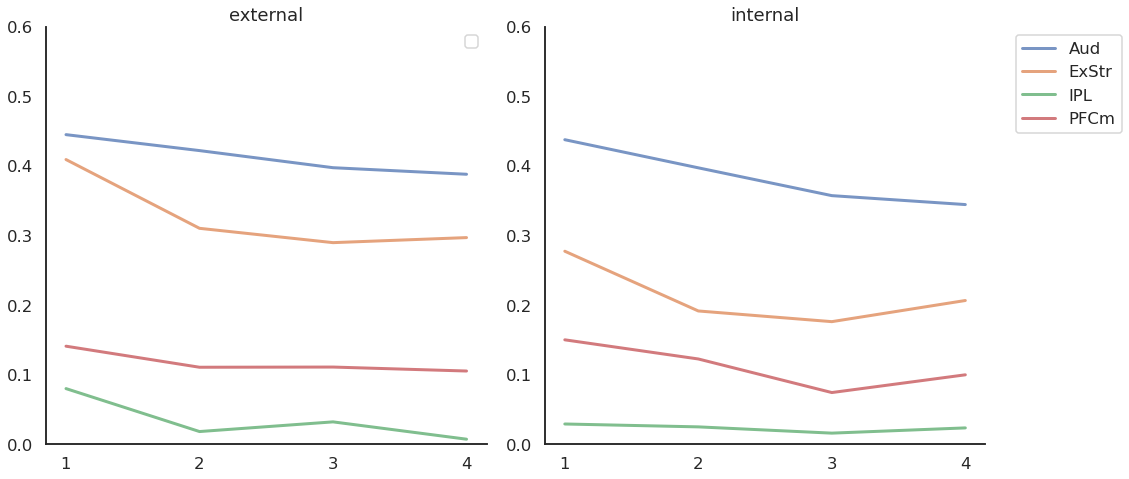

In [88]:
color_mapping = {}
xlabs = [1, 2, 3, 4]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))  # Creating subplots with 1 row and 2 columns

for i, cond in enumerate(cond_list):
    ax = axes[i]  # Selecting the appropriate subplot for the current condition

    handles = []  # Reset handles for each subplot
    for key in h_dic[cond]: #new_dic
        line, = ax.plot(h_dic[cond][key], alpha=0.75, linewidth=3, label=key.split('_')[2])
        handles.append(line)

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)
    if i == 1:  # For the right subplot (second subplot)
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend on the right subplot
    else:
        ax.legend([])  # Empty legend for the left subplot
    ax.set_ylim(0, 0.6)
    ax.set_title(cond)  # Set title according to the condition
    sns.despine()

print('CONDITION', s)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Plot only one region

In [92]:
import seaborn as sns
from matplotlib.lines import Line2D

In [89]:
list(roi_dic_aparc.keys())


['RH_SomMotB_Aud_1',
 'RH_VisCent_ExStr_4',
 'RH_DefaultA_IPL_1',
 'RH_DefaultA_PFCm_3']

In [120]:
roi_names = dict(zip(list(roi_dic_aparc.keys()), ['Auditory', 'Visual', 'rTPJ', 'DMPFC']))
roi_names

{'RH_SomMotB_Aud_1': 'Auditory',
 'RH_VisCent_ExStr_4': 'Visual',
 'RH_DefaultA_IPL_1': 'rTPJ',
 'RH_DefaultA_PFCm_3': 'DMPFC'}

In [90]:
r = 'RH_DefaultA_IPL_1'# ['RH_SomMotB_Aud_1', 'RH_VisCent_ExStr_1'] # , 'RH_DefaultA_IPL_1', 'LH_DefaultB_PFCd_3'

REGION RH_DefaultA_IPL_1


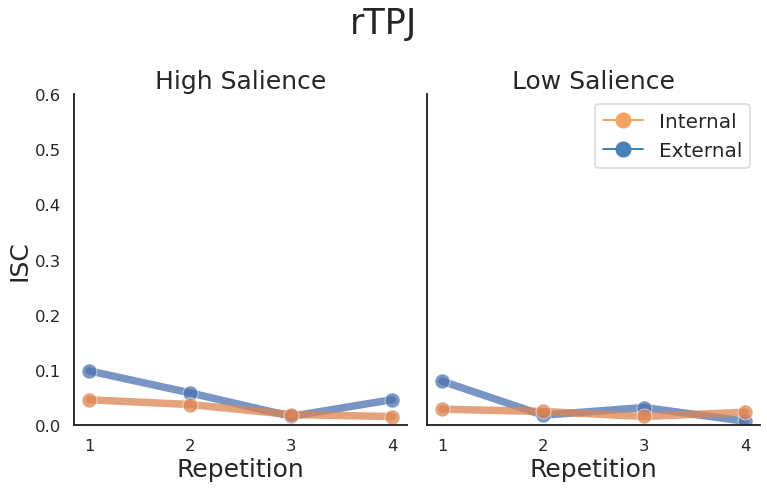

In [119]:
color_mapping = {}
s1 = 25
s2 = 35

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 7), sharex=True, sharey=True)  # Creating subplots with 1 row and 2 columns

# Custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='sandybrown', label='Internal', markersize=15),
    Line2D([0], [0], marker='o', color='steelblue', label='External', markersize=15)
]

for i, s in enumerate(sal):
    ax = axes[i]  # Selecting the appropriate subplot for the current condition

    for cond in sal[s]:  # new_dic
        sns.lineplot(data=sal[s][cond][r], alpha=0.75, ax=ax, label=cond, marker='o', linewidth=7.5, markersize=15)

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)
    if i == 1:  # For the right subplot (second subplot)
        ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
    else:
        ax.legend_.remove()

    ax.set_ylim(0, 0.6)
    ax.set_title(s.capitalize() + ' Salience', fontsize=s1)  # Set title according to the condition
    ax.set_xlabel('Repetition', fontsize=s1)  # Corrected syntax for setting xlabel
    ax.set_ylabel('ISC', fontsize=s1)  # Corrected syntax for setting ylabel
    

print('REGION', r)

plt.suptitle(roi_names[r], fontsize=s2)
sns.despine()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [147]:
'''
rsync -rvp isaacrc@scotty.princeton.edu:/jukebox/graziano/coolCatIsaac/MEI/code/analysis/plotting/* .
'''

'internal'

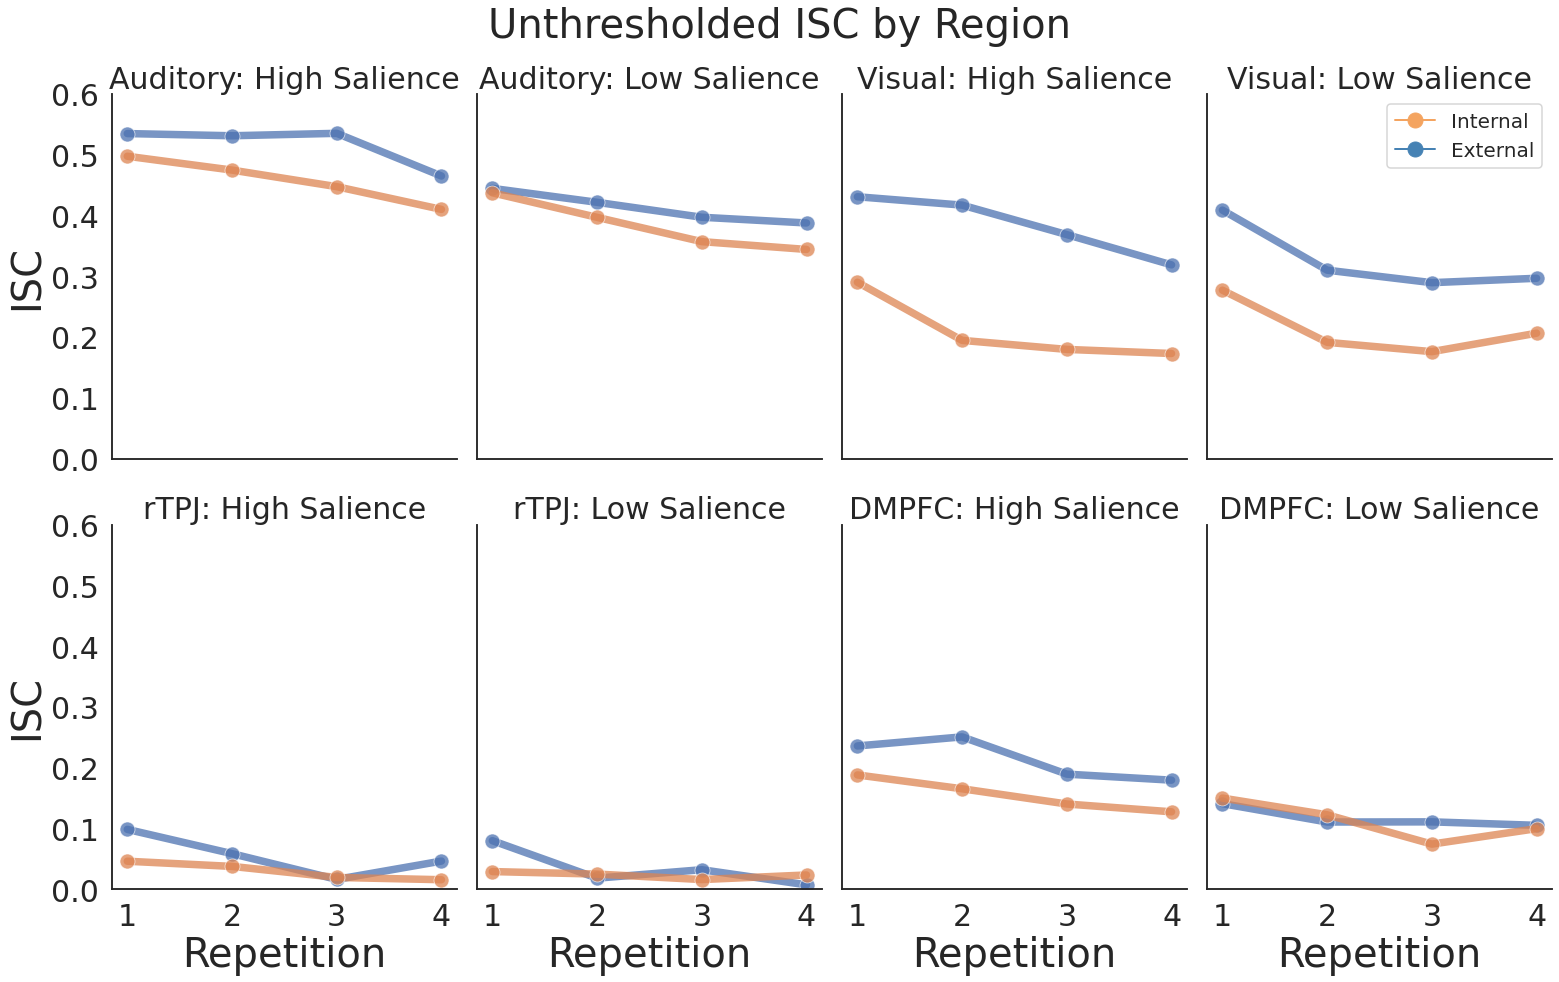

In [191]:
color_mapping = {}
s1 = 30
s2 = 40

# Define the regions
regions = ['RH_SomMotB_Aud_1', 'RH_VisCent_ExStr_4', 'RH_DefaultA_IPL_1', 'RH_DefaultA_PFCm_3']

# Create a 2x4 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 14), sharex=True, sharey=True)

# Custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='sandybrown', label='Internal', markersize=15),
    Line2D([0], [0], marker='o', color='steelblue', label='External', markersize=15)
]

# Iterate over each region
for i, region in enumerate(regions):
    row_idx = i // 2  # Calculate the row index for the subplot
    col_idx = i % 2   # Calculate the column index for the subplot
    salience = 'high' if col_idx < 2 else 'low'  # Determine salience (high or low) based on column index
    
    ax = axes[row_idx, col_idx * 2]  # Selecting the appropriate subplot for the current region and salience
    
    # Plot internal and external lines for the current region and salience
    for cond in sal[salience]:
        sns.lineplot(data=sal['high'][cond][region], alpha=0.75, ax=ax, label=cond, marker='o', linewidth=7.5, markersize=15)
    
    ax.set_ylim(0, 0.6)
    ax.set_title(f"{roi_names[region]}: {salience.capitalize()} Salience", fontsize=s1)
    ax.set_xlabel('Repetition', fontsize=s2)
    ax.set_ylabel('ISC', fontsize=s2)
    ax.set_xticks(np.arange(4))  # Set x ticks to 1 through 4
    ax.set_xticklabels(np.arange(1, 5),fontsize=s1)  # Set x tick labels to 1 through 4
    ax.tick_params(axis='y', labelsize=s1)
    
    if i==1 and col_idx == 3:
        ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
    else:
        ax.legend_.remove()

        
    ## LOW ### 
    ax = axes[row_idx, col_idx * 2 + 1]  # Selecting the appropriate subplot
    for cond in sal[salience]:
        sns.lineplot(data=sal['low'][cond][region], alpha=0.75, ax=ax, label=cond, marker='o', linewidth=7.5, markersize=15)

    ax.set_ylim(0, 0.6)
    ax.set_title(f"{roi_names[region]}: Low Salience", fontsize=s1)
    ax.set_xlabel('Repetition', fontsize=s2)
    ax.set_ylabel('ISC', fontsize=s2)
    ax.set_xticks(np.arange(4))  # Set x ticks to 1 through 4
    ax.set_xticklabels(np.arange(1, 5), fontsize=s1)  # Set x tick labels to 1 through 4
    ax.tick_params(axis='y', labelsize=s1)
    
    # legend
    # Add legend only to the first subplot in each row
    if i==1 and col_idx == 1:
        ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
    else:
        ax.legend_.remove()

        
plt.suptitle("Unthresholded ISC by Region", fontsize=s2)
sns.despine()

plt.tight_layout()  # Adjust spacing between subplots

# save
plt.savefig('plotting/region_untrhesh_isc.png')

plt.show()


In [212]:
1 //2

0

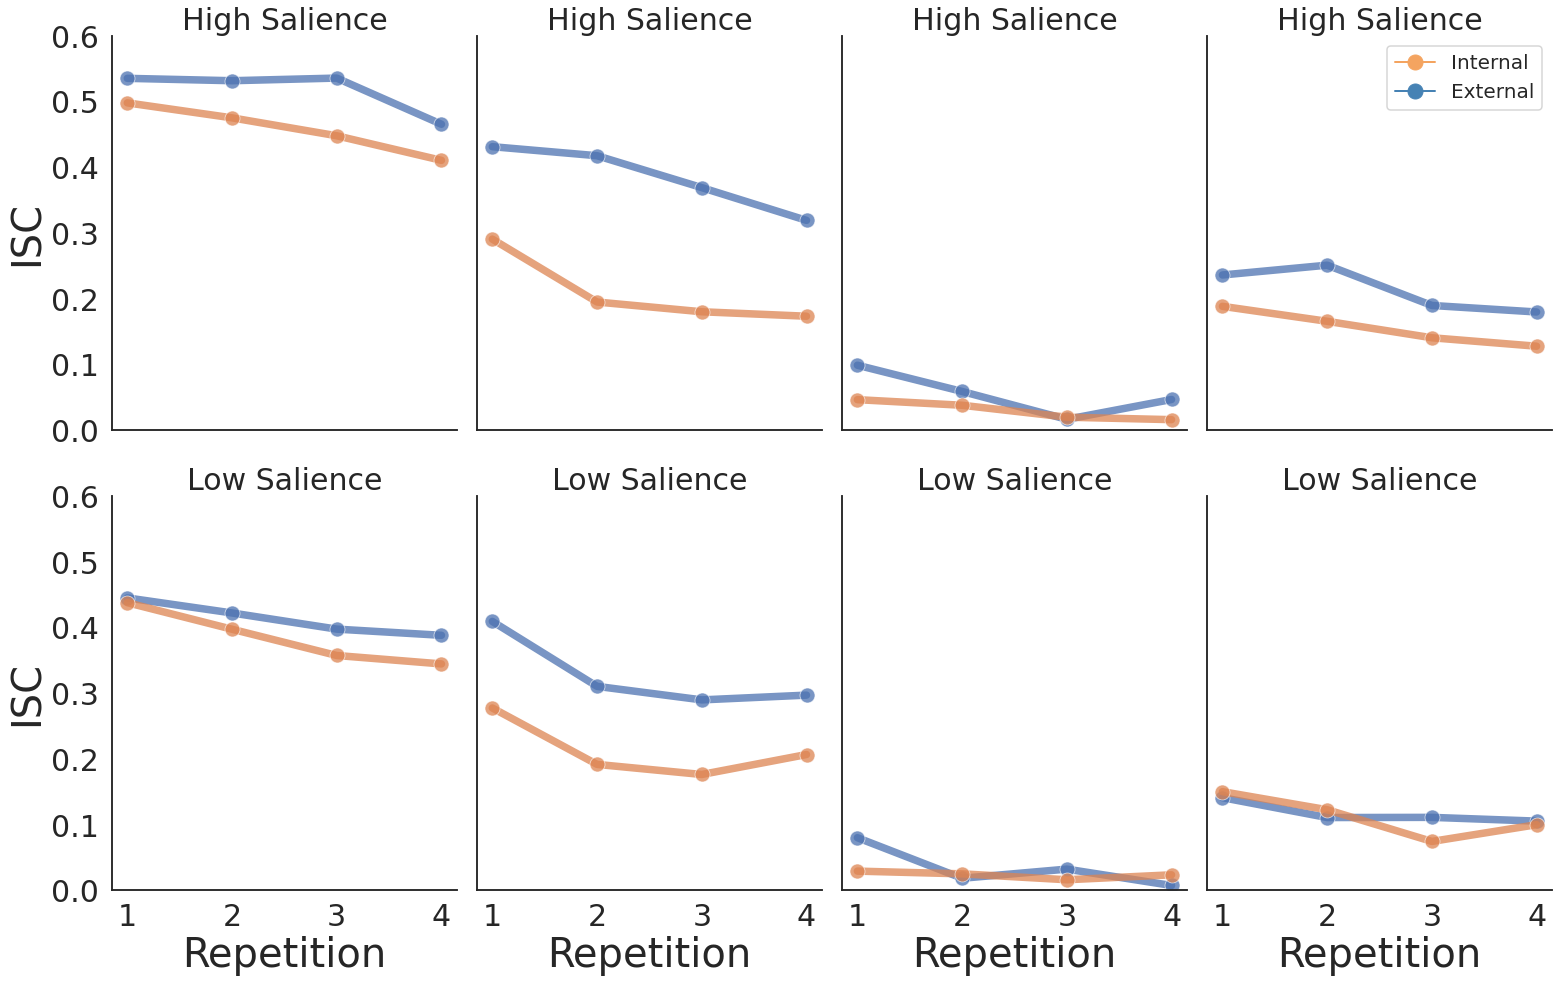

In [221]:
color_mapping = {}
s1 = 30
s2 = 40

# Define the regions
regions = ['RH_SomMotB_Aud_1', 'RH_VisCent_ExStr_4', 'RH_DefaultA_IPL_1', 'RH_DefaultA_PFCm_3']

# Create a 2x4 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 14), sharex=True, sharey=True)

# Custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='sandybrown', label='Internal', markersize=15),
    Line2D([0], [0], marker='o', color='steelblue', label='External', markersize=15)
]

# Iterate over each region
for i, region in enumerate(regions):
    row_idx = i % 2  # Calculate the row index for the subplot
    col_idx = i    # Calculate the column index for the subplot
    salience = 'high'  # Determine salience (high or low) based on column index
    
    ax = axes[0, col_idx]  # Selecting the appropriate subplot for the current region and salience
    
    # Plot internal and external lines for the current region and salience
    for cond in sal[salience]:
        sns.lineplot(data=sal['high'][cond][region], alpha=0.75, ax=ax, label=cond, marker='o', linewidth=7.5, markersize=15)
    
    ax.set_ylim(0, 0.6)
    ax.set_title(f"{salience.capitalize()} Salience", fontsize=s1) # {roi_names[region]}: 
    ax.set_xlabel('Repetition', fontsize=s2)
    ax.set_ylabel('ISC', fontsize=s2)
    ax.set_xticks(np.arange(4))  # Set x ticks to 1 through 4
    ax.set_xticklabels(np.arange(1, 5),fontsize=s1)  # Set x tick labels to 1 through 4
    ax.tick_params(axis='y', labelsize=s1)
    
    if i==3:
        ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
    else:
        ax.legend_.remove()

        
    ## LOW ### 
    salience = 'low'
    ax = axes[1, col_idx]  # Selecting the appropriate subplot
    for cond in sal[salience]:
        sns.lineplot(data=sal['low'][cond][region], alpha=0.75, ax=ax, label=cond, marker='o', linewidth=7.5, markersize=15)

    ax.set_ylim(0, 0.6)
    ax.set_title(f"Low Salience", fontsize=s1)# {roi_names[region]}: 
    ax.set_xlabel('Repetition', fontsize=s2)
    ax.set_ylabel('ISC', fontsize=s2)
    ax.set_xticks(np.arange(4))  # Set x ticks to 1 through 4
    ax.set_xticklabels(np.arange(1, 5), fontsize=s1)  # Set x tick labels to 1 through 4
    ax.tick_params(axis='y', labelsize=s1)
    
    # legend
    # Add legend only to the first subplot in each row
    if i==3 and row_idx == 0:
        ax.legend(handles=legend_elements, loc='upper right', fontsize=20)
    else:
        ax.legend_.remove()

        
#plt.suptitle("Unthresholded ISC by Region", fontsize=s2)
sns.despine()

plt.tight_layout()  # Adjust spacing between subplots

# save
plt.savefig('plotting/region_untrhesh_isc.png')

plt.show()


## plot a couple of networks - 7 net

In [225]:
cond = 'external'
mov = 'sherlock'
networkz = ['L Vis', 'R DorsAttn', 'L Default'] #'R DorsAttnB'
# static
cor_dic = {cond: {mov: {}  for mov in mov_list} for cond in cond_list}

In [226]:
##### Variables for ISC ### 

num_parc = 200 ## CHANGE ME
num_net= 7 ## CHANGE ME


###### ROI Loading ### 
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

## mask info ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")
mask_coords = np.where(mask_img)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L Vis', 'L SomMot'] 
 total nets: 14


In [227]:
isc_nii_nt = isc_nii_nt_all[cond][mov]
isc_nii_nt

{1: <nibabel.nifti1.Nifti1Image at 0x7ff760ed9d90>,
 2: <nibabel.nifti1.Nifti1Image at 0x7ff760ed9e50>,
 3: <nibabel.nifti1.Nifti1Image at 0x7ff75cda0750>,
 4: <nibabel.nifti1.Nifti1Image at 0x7ff75e1ed4d0>}

In [228]:
for run in run_list:
    # Convert to 4d numpy array
    f_dat_4d = isc_nii_nt[run].get_fdata()

    for net_lab in network_labels:
        targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
        #print(net_lab)

        temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
        if net_lab not in cor_dic[cond][mov]:
            cor_dic[cond][mov][net_lab] = [np.round(np.nanmean(temp),5)]
            #print(np.round(np.nanmean(temp),5))
        else:
            cor_dic[cond][mov][net_lab].append(np.round(np.nanmean(temp),5))

In [229]:

new_dic = {}
for net in networkz:
    new_dic[net] = cor_dic[cond][mov][net]

In [230]:
new_dic

{'L Vis': [0.44218, 0.36369, 0.34273, 0.28567],
 'R DorsAttn': [0.32626, 0.22756, 0.16404, 0.1255],
 'L Default': [0.19093, 0.1757, 0.1268, 0.0924]}

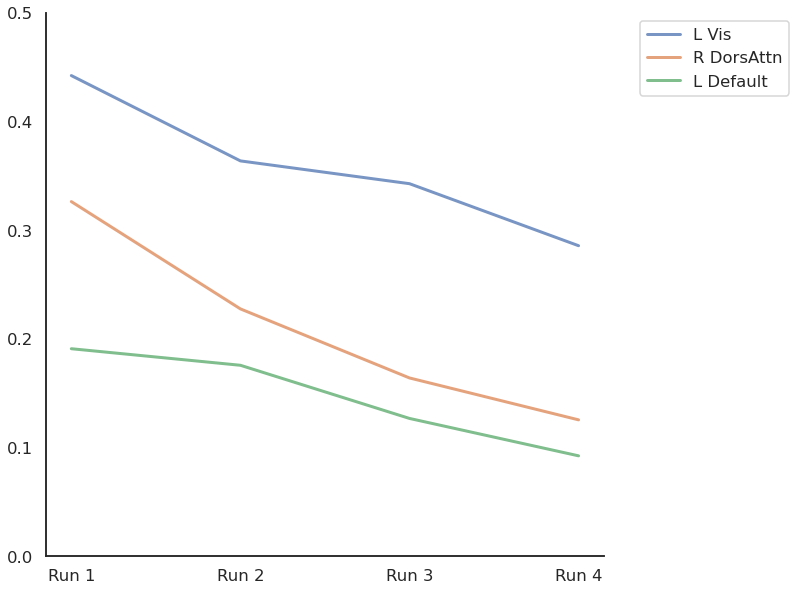

In [231]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

color_mapping = {}
handles = []
for key in new_dic:
    line, = ax.plot(new_dic[key], alpha=0.75, linewidth=3, label=key)
    handles.append(line)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 0.5)
sns.despine()
plt.show()

## bar graph of sig voxels

In [67]:
#sigvox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()
sigvox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()

In [68]:
run_list = [1, 2, 3, 4]
cond = 'internal'
mov_list = ['sherlock',  'shrek','office','cake', 'brushing', 'oragami']


In [69]:
sigvox[cond]['office']

{1: <nibabel.nifti1.Nifti1Image at 0x7fb482e92e10>,
 2: <nibabel.nifti1.Nifti1Image at 0x7fb482fd3bd0>,
 3: <nibabel.nifti1.Nifti1Image at 0x7fb482e92fd0>,
 4: <nibabel.nifti1.Nifti1Image at 0x7fb482fb7b10>}

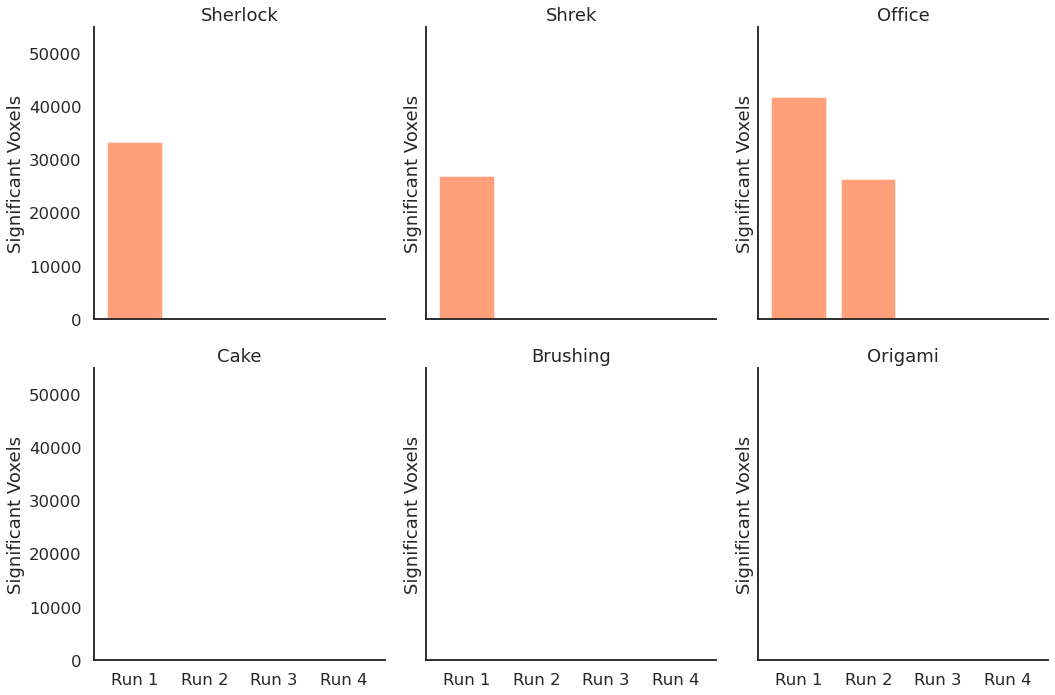

In [70]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

## colors
color = 'lightsalmon' if cond == 'internal' else 'steelblue'

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

for idx, mov in enumerate(mov_list):
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][mov][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])
    ax = axes[int(idx / 3), idx % 3]
    ax.bar(x_labels, run_count, color=color)
    if mov == 'oragami': mov = 'origami'
    ax.set_title(mov.capitalize())
    ax.set_ylim(0, 55000)
    #ax.set_xlabel('Runs')
    ax.set_ylabel('Significant Voxels')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()
        
        
        

## bar graph of THRESHOLDED voxels

In [8]:
#sigvox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()
nt_vox = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [13]:
run_list = [1, 2, 3, 4]
cond = 'external'
mov_list = ['sherlock',  'shrek','office','cake', 'brushing', 'oragami']


In [14]:
nt_vox[cond]['office']

{1: <nibabel.nifti1.Nifti1Image at 0x7f8f78ceced0>,
 2: <nibabel.nifti1.Nifti1Image at 0x7f8f78cecf90>,
 3: <nibabel.nifti1.Nifti1Image at 0x7f8f78c7f090>,
 4: <nibabel.nifti1.Nifti1Image at 0x7f8f78c7f150>}

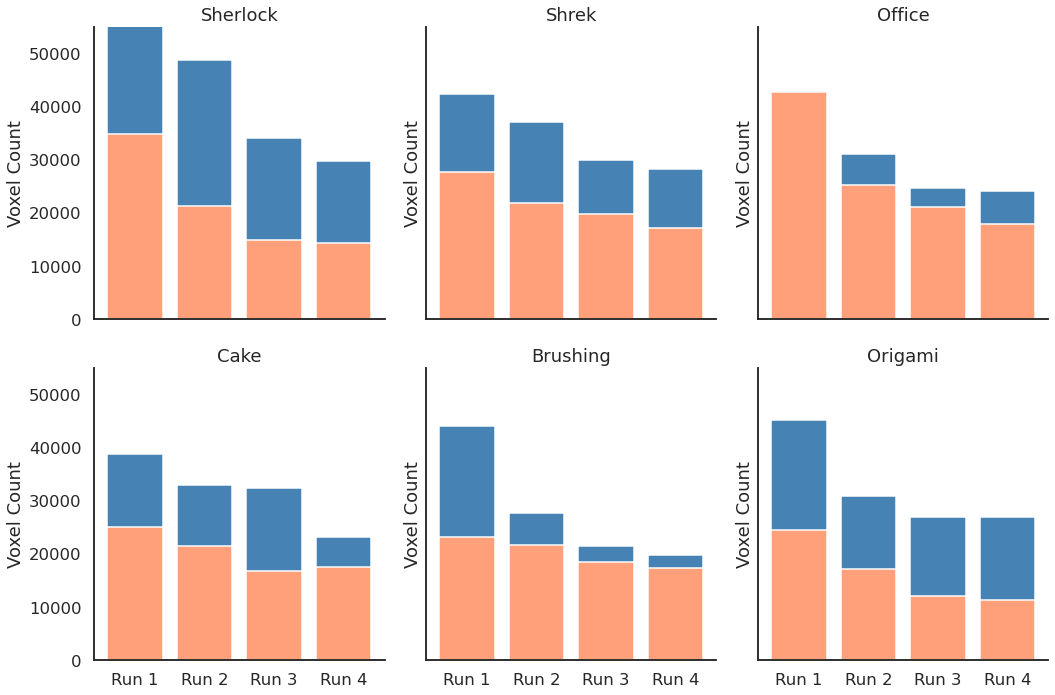

In [19]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']
cond_list = ['external', 'internal']
thresh = .1

## colors
color = 'lightsalmon' if cond == 'internal' else 'steelblue'

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

for cond in cond_list:
    color = 'lightsalmon' if cond == 'internal' else 'steelblue'
    for idx, mov in enumerate(mov_list):
        run_count = []
        #for cond in cond_list:
        for run in run_list:
            x_3d = nt_vox[cond][mov][run].get_fdata()
            run_count.append(x_3d[x_3d > thresh].shape[0])
        ax = axes[int(idx / 3), idx % 3]
        ax.bar(x_labels, run_count, color=color)
        if mov == 'oragami': mov = 'origami'
        ax.set_title(mov.capitalize())
        ax.set_ylim(0, 55000)
        #ax.set_xlabel('Runs')
        ax.set_ylabel('Voxel Count')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()
        
        
        

## side by side bar 

In [7]:
nt_vox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()
#nt_vox = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [8]:
run_list = [1, 2, 3, 4]
cond = 'external'
mov_list = ['sherlock',  'shrek','office','cake', 'brushing', 'oragami']


In [9]:
nt_vox[cond]['office']

{1: <nibabel.nifti1.Nifti1Image at 0x7fbd3b55d910>,
 2: <nibabel.nifti1.Nifti1Image at 0x7fbd3b55d510>,
 3: <nibabel.nifti1.Nifti1Image at 0x7fbd3b556610>,
 4: <nibabel.nifti1.Nifti1Image at 0x7fbd3b556fd0>}

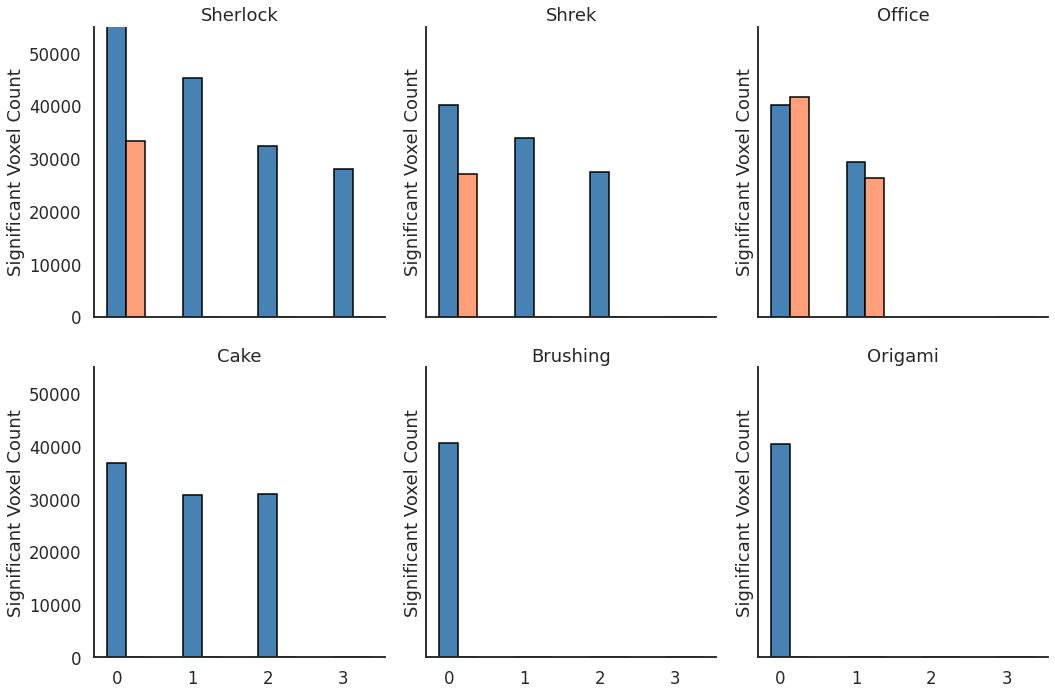

In [10]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']
cond_list = ['external', 'internal']
thresh = 0

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

n = len(x_labels)
r = np.arange(n)
width = 0.25


for idx, mov in enumerate(mov_list):
    ax = axes[int(idx / 3), idx % 3]
    for cond in cond_list:
        color = 'lightsalmon' if cond == 'internal' else 'steelblue'
        run_count = []
        for run in run_list:
            x_3d = nt_vox[cond][mov][run].get_fdata()
            run_count.append(x_3d[x_3d > thresh].shape[0])

        if cond == 'external':
            ax.bar(r, run_count, color=color, width=width, edgecolor='black', label='External')
        else:
            ax.bar(r + width, run_count, color=color, width=width, edgecolor='black', label='Internal' )

                
                
            
    if mov == 'oragami': mov = 'origami'
    ax.set_title(mov.capitalize())
    ax.set_ylim(0, 55000)
    #ax.set_xlabel('Runs')
    ax.set_ylabel('Significant Voxel Count')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

## side by side bar by SALIENCE

In [25]:
nt_vox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()
#nt_vox = np.load(f'{isc_dir}/n39_isc_noThresh_nii_dic.npy', allow_pickle = True).item()


In [26]:
run_list = [1, 2, 3, 4]
cond = 'external'
mov_list = ['sherlock',  'shrek','office','cake', 'brushing', 'oragami']


In [27]:
nt_vox[cond]['office']

{1: <nibabel.nifti1.Nifti1Image at 0x7f13bb75d150>,
 2: <nibabel.nifti1.Nifti1Image at 0x7f13bb75df50>,
 3: <nibabel.nifti1.Nifti1Image at 0x7f13bb75d890>,
 4: <nibabel.nifti1.Nifti1Image at 0x7f13bb6de390>}

In [29]:
high_movies =['shrek', 'office', 'sherlock']
low_movies = ['brushing', 'oragami', 'cake']

In [30]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']
cond_list = ['external', 'internal']
thresh = 0

n = len(x_labels)
r = np.arange(n)
width = 0.25

high_dict = {'internal': [], 'external': []}
low_dict = {'internal': [], 'external': []}

for idx, mov in enumerate(mov_list):
    cond_dic = {}
    for cond in cond_list:
        run_count = []
        for run in run_list:
            x_3d = nt_vox[cond][mov][run].get_fdata()
            run_count.append(x_3d[x_3d > thresh].shape[0])

        if mov in high_movies:  # Replace high_movies with the list of high-category movies
            if cond == 'external':
                high_dict['external'].append(run_count)
            else:
                high_dict['internal'].append(run_count)
        else:
            if cond == 'external':
                low_dict['external'].append(run_count)
            else:
                low_dict['internal'].append(run_count)

# Now, high_dict and low_dict contain separate dictionaries for 'high' and 'low' movies
# Each dictionary contains 'internal' and 'external' keys with run_counts stacked properly
sal = {'high': high_dict, 'low': low_dict}

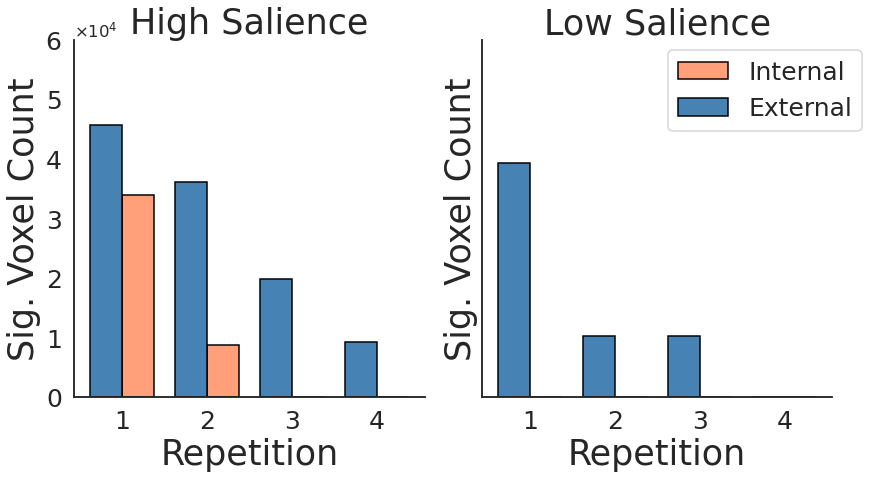

In [53]:
# sizes
s1 = 25
s2 = 35
# Sample data
x_labels = [1, 2, 3, 4]
cond_list = ['internal', 'external']
thresh = 0

# Create 6 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7), sharex=True, sharey=True)

n = len(x_labels)
r = np.arange(n)
width = 0.375

legend_handles = []  # To store handles for legend
legend_labels = []  # To store labels for legend

for idx, sal_cond in enumerate(sal):
    ax = axes[idx % 2]
    for cond in cond_list:
        color = 'lightsalmon' if cond == 'internal' else 'steelblue'
        run_count = np.mean(np.array(sal[sal_cond][cond]), axis=0)

        if cond == 'external':
            bars = ax.bar(r, run_count, color=color, width=width, edgecolor='black', label='External')
        else:
            bars = ax.bar(r + width, run_count, color=color, width=width, edgecolor='black', label='Internal')
            
        if idx == 0:
            # Collect handles and labels for legend
            legend_handles.append(bars)
            legend_labels.append('External' if cond == 'external' else 'Internal')

    ax.set_title(sal_cond.capitalize() + ' Salience', fontsize=s2)
    ax.set_ylim(0, 60000)
    ax.set_ylabel('Sig. Voxel Count', fontsize=s2)  # Increase the size of y-axis label
    ax.set_xlabel('Repetition',fontsize=s2)

    # Calculate the position of each group of bars
    bar_positions = [x + width / 2 for x in r]
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(x_labels, fontsize=s1)  # Increase the size of x-tick labels

    # Set y-axis tick labels to scientific notation
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Adjust as needed
    ax.yaxis.set_major_formatter(formatter)

    # Increase the size of y-axis tick labels
    ax.tick_params(axis='y', labelsize=s1)

# Add legend outside the subplots
fig.legend(legend_handles, legend_labels, loc='upper center', fontsize=s1, bbox_to_anchor=(0.9, .9))



# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

plt.savefig('plotting/high-low_isc.png')

# Show the plot
plt.show()


# One movie

In [11]:
from matplotlib.ticker import ScalarFormatter


In [12]:
sigvox = np.load(f'{isc_dir}/n39_isc_sigvox_nii_dic.npy', allow_pickle = True).item()
'''
rsync -rvp isaacrc@scotty.princeton.edu:/jukebox/graziano/coolCatIsaac/MEI/code/analysis/plotting/* .

'''

'\nrsync -rvp isaacrc@scotty.princeton.edu:/jukebox/graziano/coolCatIsaac/MEI/code/analysis/plotting/* .\n\n'

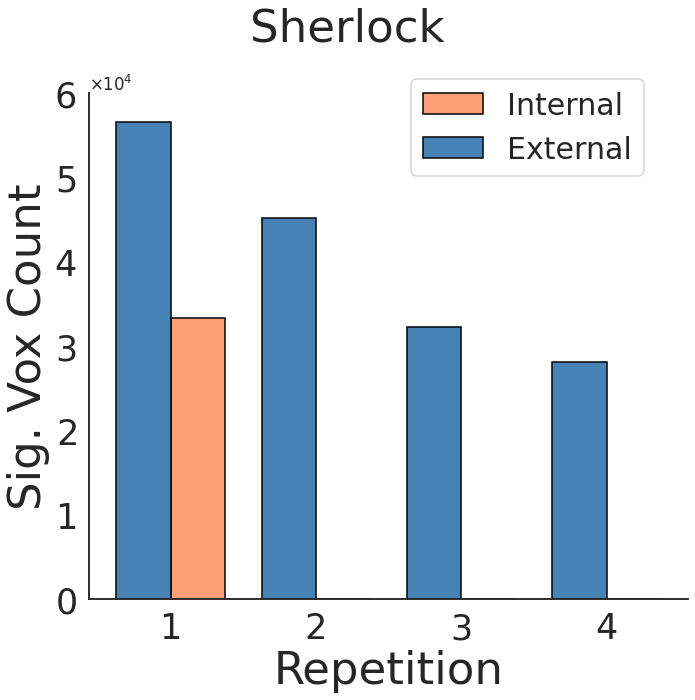

In [13]:
s1 = 35
s2 = 45
# Sample data
x_labels = [1, 2, 3, 4]
cond_list = ['internal', 'external']
selected_movie = 'sherlock'
thresh = 0
run_list = [1, 2, 3, 4]

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 10))

n = len(x_labels)
r = np.arange(n)
width = 0.375

legend_handles = []  # To store handles for legend
legend_labels = []  # To store labels for legend

for cond in cond_list:
    color = 'lightsalmon' if cond == 'internal' else 'steelblue'
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][selected_movie][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])

    if cond == 'external':
        bars = ax.bar(r, run_count, color=color, width=width, edgecolor='black', label='External')
    else:
        bars = ax.bar(r + width, run_count, color=color, width=width, edgecolor='black', label='Internal')

    # Collect handles and labels for legend
    legend_handles.append(bars)
    legend_labels.append('External' if cond == 'external' else 'Internal')

    #ax.set_title(selected_movie.capitalize())
    ax.set_ylim(0, 60000)
    ax.set_ylabel('Sig. Vox Count', fontsize=s2)
    ax.set_xlabel('Repetition',fontsize=s2)

# Calculate the position of each group of bars
bar_positions = r + width / 2
ax.set_xticks(bar_positions)
ax.set_xticklabels(x_labels, fontsize=s1)  # Set the x-tick labels

# Set y-axis tick labels to scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))  # Adjust as needed
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis='y', labelsize=s1)

# Add legend outside the plot
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.75, .9), fontsize=s1-5)
fig.suptitle('Sherlock', fontsize=s2)

# Adjust spacing
plt.tight_layout()
sns.despine()

# save
plt.savefig('plotting/Sherlock_isc.png')

# Show the plot
plt.show()


## get count of sig voxels per video

In [16]:
# Sample data
run_list = [1, 2, 3, 4]
cond = 'internal'
mov_list = ['sherlock',  'shrek','office','cake', 'brushing', 'oragami']


for idx, mov in enumerate(mov_list):
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][mov][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])
    print(f'movie {mov}: {run_count}')

        
        
        

movie sherlock: [33373, 0, 0, 0]
movie shrek: [26995, 0, 0, 0]
movie office: [41705, 26355, 0, 0]
movie cake: [0, 0, 0, 0]
movie brushing: [0, 0, 0, 0]
movie oragami: [0, 0, 0, 0]


# one video, one condition

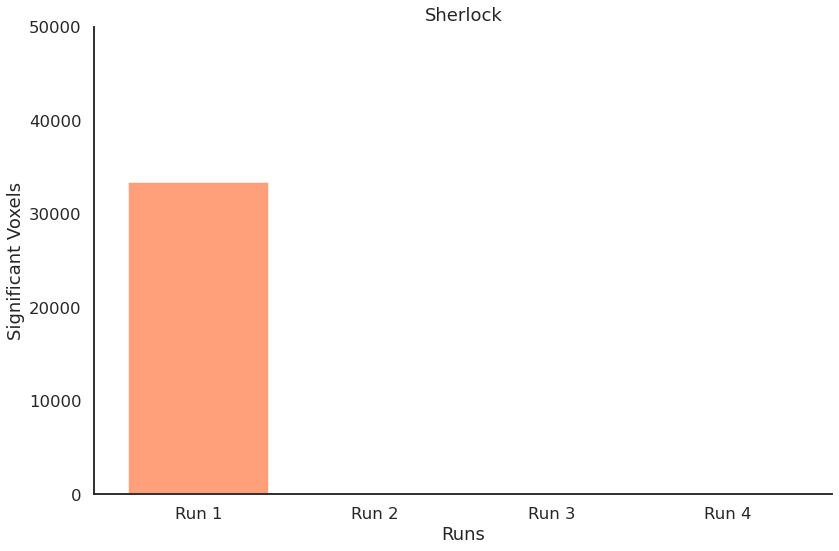

In [325]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

# Colors
color = 'lightsalmon' if cond == 'internal' else 'steelblue'

# Select the specific movie to plot
selected_movie = 'sherlock'

# Initialize lists to store data
run_count = []

# one plot
one_plot = True

for idx, run in enumerate(run_list):
    if idx > 0 and one_plot == True:
        run_count.append(0)
        continue
    x_3d = sigvox[cond][selected_movie][run].get_fdata()
    run_count.append(x_3d[x_3d > 0].shape[0])

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
x = range(len(x_labels))
ax.bar(x, run_count, color=color)

# Set x-axis labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Runs')
ax.set_ylim(0, 50000) 


# Set y-axis label
ax.set_ylabel('Significant Voxels')

# Set the title
ax.set_title(f'{selected_movie.capitalize()}')

# Adjust spacing
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()



## simulate

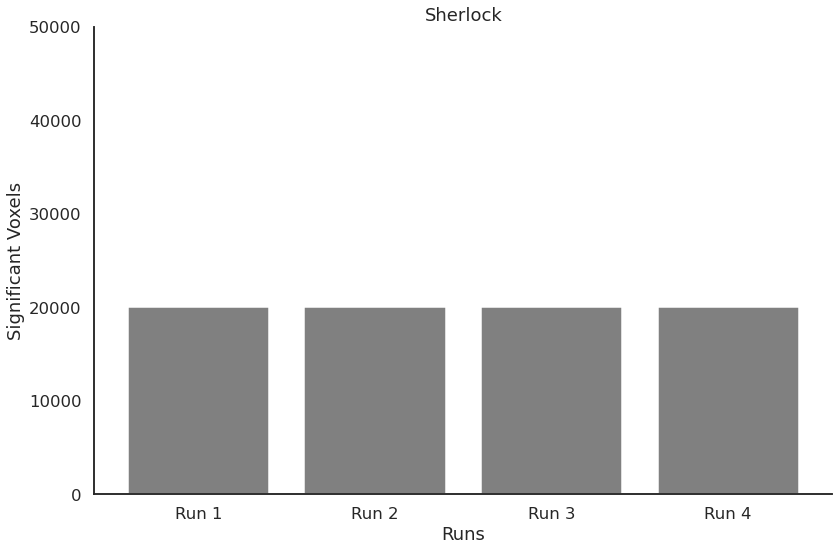

In [341]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

# Colors
#color = 'lightsalmon' if cond == 'internal' else 'steelblue'
color = 'gray'

# Select the specific movie to plot
selected_movie = 'sherlock'

# Initialize lists to store data
run_count = [20000, 20000, 20000, 20000]


# Create a single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
x = range(len(x_labels))
ax.bar(x, run_count, color=color)

# Set x-axis labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Runs')
#ax.set_ymin(60000)
ax.set_ylim(0, 50000) 

# Set y-axis label
ax.set_ylabel('Significant Voxels')

# Set the title
ax.set_title(f'{selected_movie.capitalize()}')

# Adjust spacing
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()



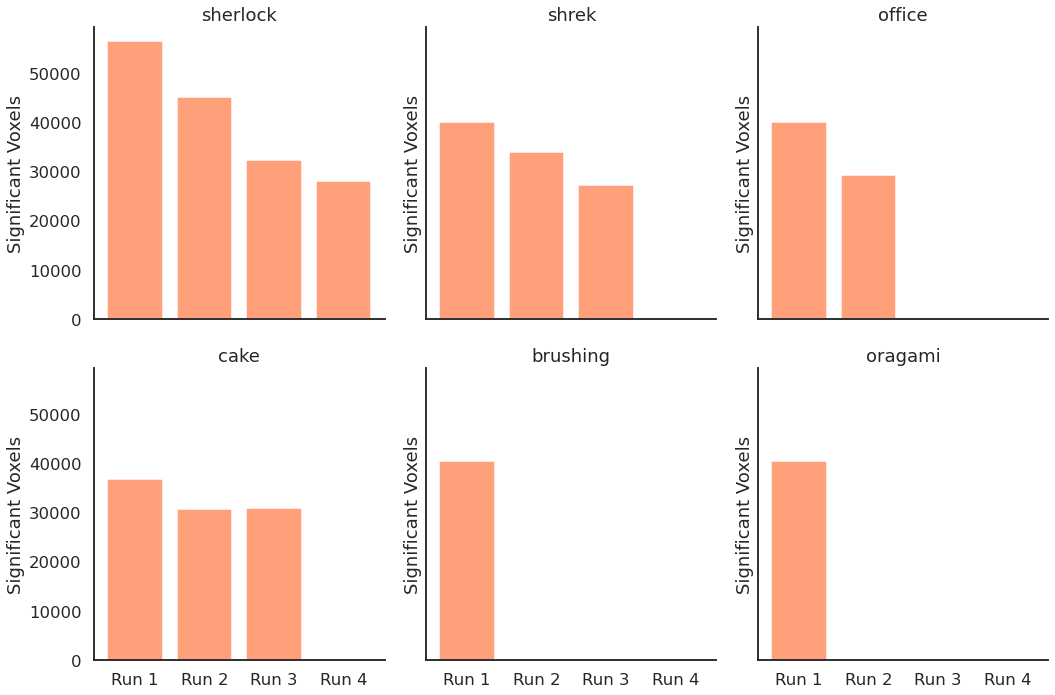

In [37]:
# Sample data
x_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']

# Create 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharex = True, sharey = True)

for idx, mov in enumerate(mov_list):
    run_count = []
    for run in run_list:
        x_3d = sigvox[cond][mov][run].get_fdata()
        run_count.append(x_3d[x_3d > 0].shape[0])
    ax = axes[int(idx / 3), idx % 3]
    ax.bar(x_labels, run_count, color='lightsalmon')
    ax.set_title(f'{mov}')
    
    #ax.set_xlabel('Runs')
    ax.set_ylabel('Significant Voxels')
        


# Adjust spacing between subplots
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()
        
        
        

In [127]:
# Threshold value
threshold = 0.03

# Get a boolean mask for values greater than the threshold
mask = x_3d < threshold

# Use the boolean mask to extract values from the original array
values_above_threshold = x_3d[mask]

print(values_above_threshold.shape)

(5,)


In [128]:
nonnan_mask = ~np.isnan(x_3d)
nonnan_mask[nonnan_mask == True].shape

(40612,)

In [ ]:
for key in vis_dic: 

In [136]:
list(vis_dic.keys())[:3]

['Internal-office-1', 'Internal-brushing-1', 'Internal-oragami-1']

In [ ]:
conditions = ['External', "Internal"]
mov = 'sherlock'
external = {}
internal = {}

for cond in conditions:
    for key in cor_dic:
        key_splits = key.split('-')
        if key_splits[0] == cond and key_splits[1] == mov and key_splits[2] in networkz:
            print(key)
            new_dic[cond + '-' + key_splits[2]] = cor_dic[key]

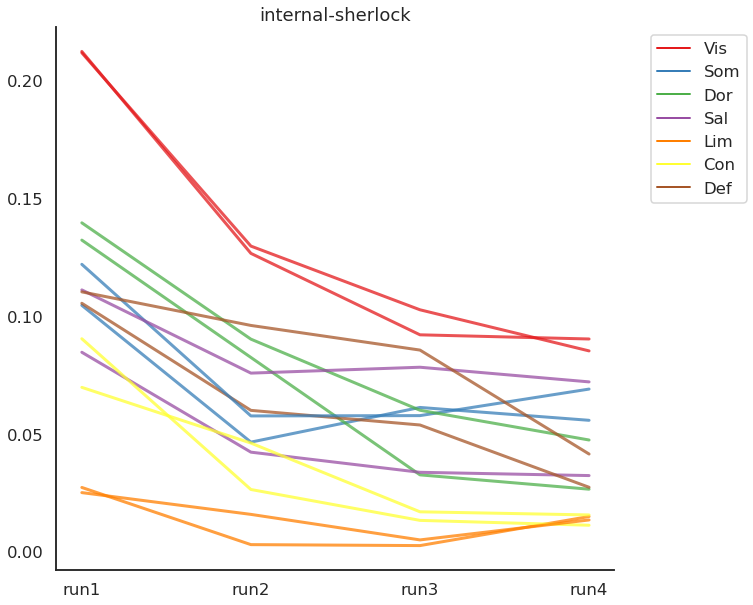

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in cor_dic[cond][mov]:
    prefix = key.split()[1][:3]  # Get the prefix of the key
    if prefix not in color_mapping:
        color_mapping[prefix] = sns.color_palette("Set1", n_colors=len(color_mapping) + 1)[len(color_mapping)]
        handles.append(ax.plot([], [], label=prefix, color=color_mapping[prefix])[0])  # Add a dummy line handle for the legend

    ax.plot(cor_dic[cond][mov][key], color=color_mapping[prefix], alpha=0.75, linewidth = 3)

ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.set_title(f'{cond}-{mov}')

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()


### plot each line 

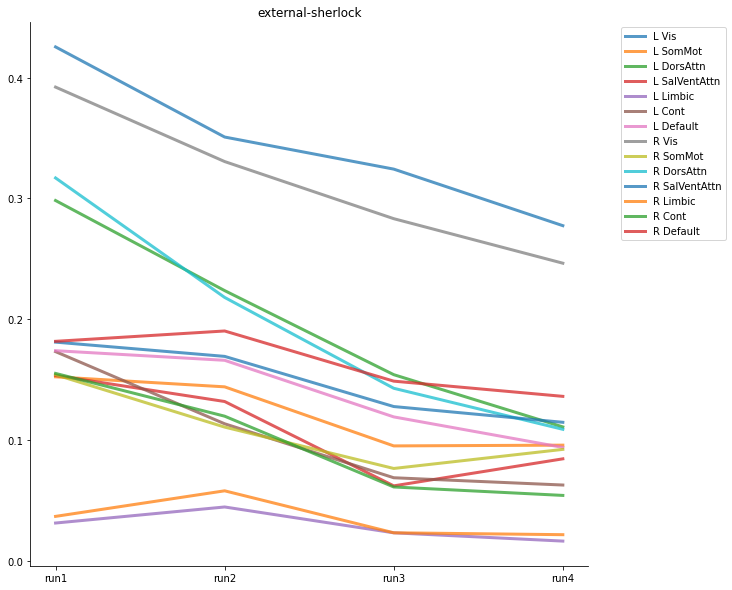

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
xlabs = ['run1', 'run2', 'run3', 'run4']

color_mapping = {}
handles = []
for key in cor_dic[cond][mov]:
    line, = ax.plot(cor_dic[cond][mov][key], alpha=0.75, linewidth=3)
    handles.append(line)  # Add the line object to handles list for legend
    
ax.set_xticks(range(len(xlabs)))
ax.set_xticklabels(xlabs)
ax.set_title(f'{cond}-{mov}')

# Set legend labels to the keys
plt.legend(handles=handles, labels=cor_dic[cond][mov].keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

sns.despine()
plt.show()


# rerun ISC to get raw correlations, not q values

In [19]:
from utils_anal import load_epi_data, resample_atlas, get_network_labels

In [20]:
## here we just remove the portion of the code that threshholds 
runs = [1, 2, 3, 4]
conditions = ["External"]
mov_list = ['office', 'brushing', 'origami', 'shrek', 'cake', 'sherlock']
#mov_list = [ 'sherlock']



remove_trs = 4
vis_dic = {}

In [21]:
num_parc = 200 ## CHANGE ME
num_net= 17 ## CHANGE ME


In [22]:
# LOAD ATLAS #
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)


# ### get network labels

# Load in network labels for each parcell, parcel UNspecific network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:201
shape of atlas nii object (78, 93, 65)
two networks: ['L VisCent', 'L VisPeri'] 
 total nets: 34


In [23]:
for net_lab in network_labels:
    targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
    print(net_lab)

L VisCent
L VisPeri
L SomMotA
L SomMotB
L DorsAttnA
L DorsAttnB
L SalVentAttnA
L SalVentAttnB
L LimbicB
L LimbicA
L ContA
L ContB
L ContC
L DefaultA
L DefaultB
L DefaultC
L TempPar
R VisCent
R VisPeri
R SomMotA
R SomMotB
R DorsAttnA
R DorsAttnB
R SalVentAttnA
R SalVentAttnB
R LimbicB
R LimbicA
R ContA
R ContB
R ContC
R DefaultA
R DefaultB
R DefaultC
R TempPar


In [75]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [73]:
## load ISC 
loaded_int_isc = np.load(f'{isc_dir}/int_isc.npz')
loaded_ext_isc = np.load(f'{isc_dir}/ext_isc.npz')
## get template image #
vis_dic = np.load(f'{isc_dir}/vis_dic_nothresh.npy', allow_pickle=True).item()
bpress_nii = vis_dic['External-sherlock-1']
#number of bootstraps: 
n_boot = 5

In [71]:
conditions = ['External', 'Internal']

['External', 'Internal']

In [76]:
for cond in conditions:
    print(f'START {cond}')
    if cond == "External":
        targ_dic = loaded_ext_isc
    else:
        targ_dic = loaded_int_isc
        
    for run in runs:
        for mov in mov_list:
    
            # select movie and run from loaded data ** account for indexing
            data = targ_dic[mov][...,run - 1,:]
            print('loaded!')
            print(f'{mov} run {run} shape is: {data.shape}')

            # Z-score time series for each voxel
            data = zscore(data[remove_trs:,:,:], axis=0)

            # Leave-one-out approach
            iscs = isc(data, pairwise=False, tolerate_nans=.8)

            # Check shape of output ISC values
            print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
                  f"left-out subjects and {iscs.shape[1]} voxel(s)")

            # Compute mean ISC (with Fisher transformation)
            mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

            print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
                  f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
                  f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


            # Compute median ISC
            median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                                    axis=0)

            print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
                  f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
                  f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

            # Run bootstrap hypothesis test on ISCs
            observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                                          ci_percentile=95,
                                                          summary_statistic='median',
                                                          n_bootstraps=n_boot)


            # Get number of NaN voxels
            n_nans = np.sum(np.isnan(observed))
            print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
                  f"({n_nans / observed.shape[0] * 100:.2f}%)")

            # Get voxels without NaNs
            nonnan_mask = ~np.isnan(observed)
            nonnan_coords = np.where(nonnan_mask)

            # Mask both the ISC and p-value map to exclude NaNs
            nonnan_isc = observed[nonnan_mask]
            nonnan_p = p[nonnan_mask]

            # Get FDR-controlled q-values
            nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
            threshold = .05
            print(f"{np.sum(nonnan_q < threshold)} significant voxels "
                  f"controlling FDR at {threshold}")

            # Threshold ISCs according FDR-controlled threshold
            #nonnan_isc[nonnan_q >= threshold] = np.nan

            # Reinsert thresholded ISCs back into whole brain image
            isc_thresh = np.full(observed.shape, np.nan)
            isc_thresh[nonnan_coords] = nonnan_isc

            # Create empty 3D image and populate
            # with thresholded ISC values
            isc_img = np.full(ref_nii.shape, np.nan)
            isc_img[mask_coords] = isc_thresh

            # Convert to NIfTI image
            isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)
            
            # Save
            vis_dic[f'{cond}-{mov}-{run}'] = isc_nii
            print(f'\nfinish {cond}-{mov}-{run}\n')
            
            np.save(f'{isc_dir}/vis_dic_nothresh.npy', vis_dic)
            
            # DO rois # 
            # Convert to 4d numpy array
            f_dat_4d = isc_nii.get_fdata()
            
            for net_lab in network_labels:
                targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
                print(net_lab)
            
                temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
                if f'{cond}-{mov}-{net_lab}' not in cor_dic:
                    cor_dic[f'{cond}-{mov}-{net_lab}'] = [np.round(np.nanmean(temp),5)]
                else:
                    cor_dic[f'{cond}-{mov}-{net_lab}'].append(np.round(np.nanmean(temp),5))
            

START External
loaded!
office run 1 shape is: (106, 112179, 17)
ISC values shape = (17, 112179) 
i.e., 17 left-out subjects and 112179 voxel(s)


KeyboardInterrupt: 

In [ ]:
np.save(f'{isc_dir}/isc_dic_6mov_17net_400parc.npy', cor_dic)